In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
JSON_FILE = "system_metrics.json"
with open(JSON_FILE, "r") as f:
    data = json.load(f)

In [3]:
df = pd.DataFrame(data)
print(df.head())
print(df.describe())

  timestamp   cpu   ram  disk   net_sent    net_recv  notepad_running
0  07:33:28  12.6  78.4  37.8  63.401973  876.555230                0
1  07:33:33  11.2  78.4  37.8  63.478015  876.567491                0
2  07:33:38  10.3  78.4  37.8  63.563416  876.589496                0
3  07:33:43  11.1  78.8  37.8  63.639262  876.600947                0
4  07:33:48  14.5  79.0  37.8  63.729137  876.615638                0
             cpu         ram        disk    net_sent     net_recv  \
count  500.00000  500.000000  500.000000  500.000000   500.000000   
mean    16.20980   82.471800   37.807200   90.926576   892.563261   
std      5.92014    3.497733    0.025875   16.479933    44.437813   
min      9.80000   75.800000   37.800000   63.401973   876.555230   
25%     12.20000   79.800000   37.800000   77.077511   878.897276   
50%     14.20000   81.200000   37.800000   89.987561   881.003050   
75%     18.60000   86.300000   37.800000  104.544653   883.146357   
max     46.60000   88.300000

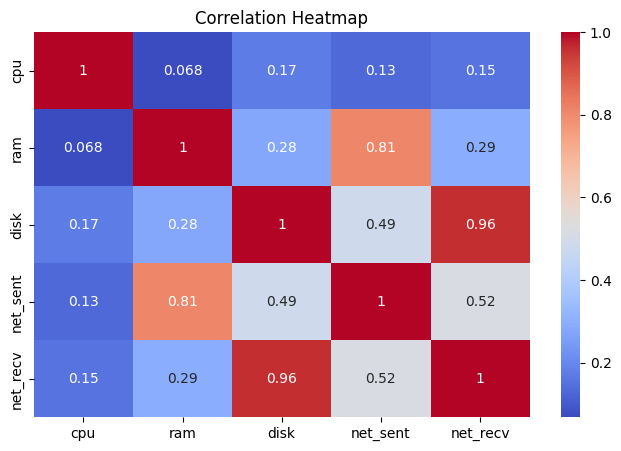

In [4]:
# Correlation heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(df[["cpu","ram","disk","net_sent","net_recv"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.savefig("haetmap.png")
plt.show()

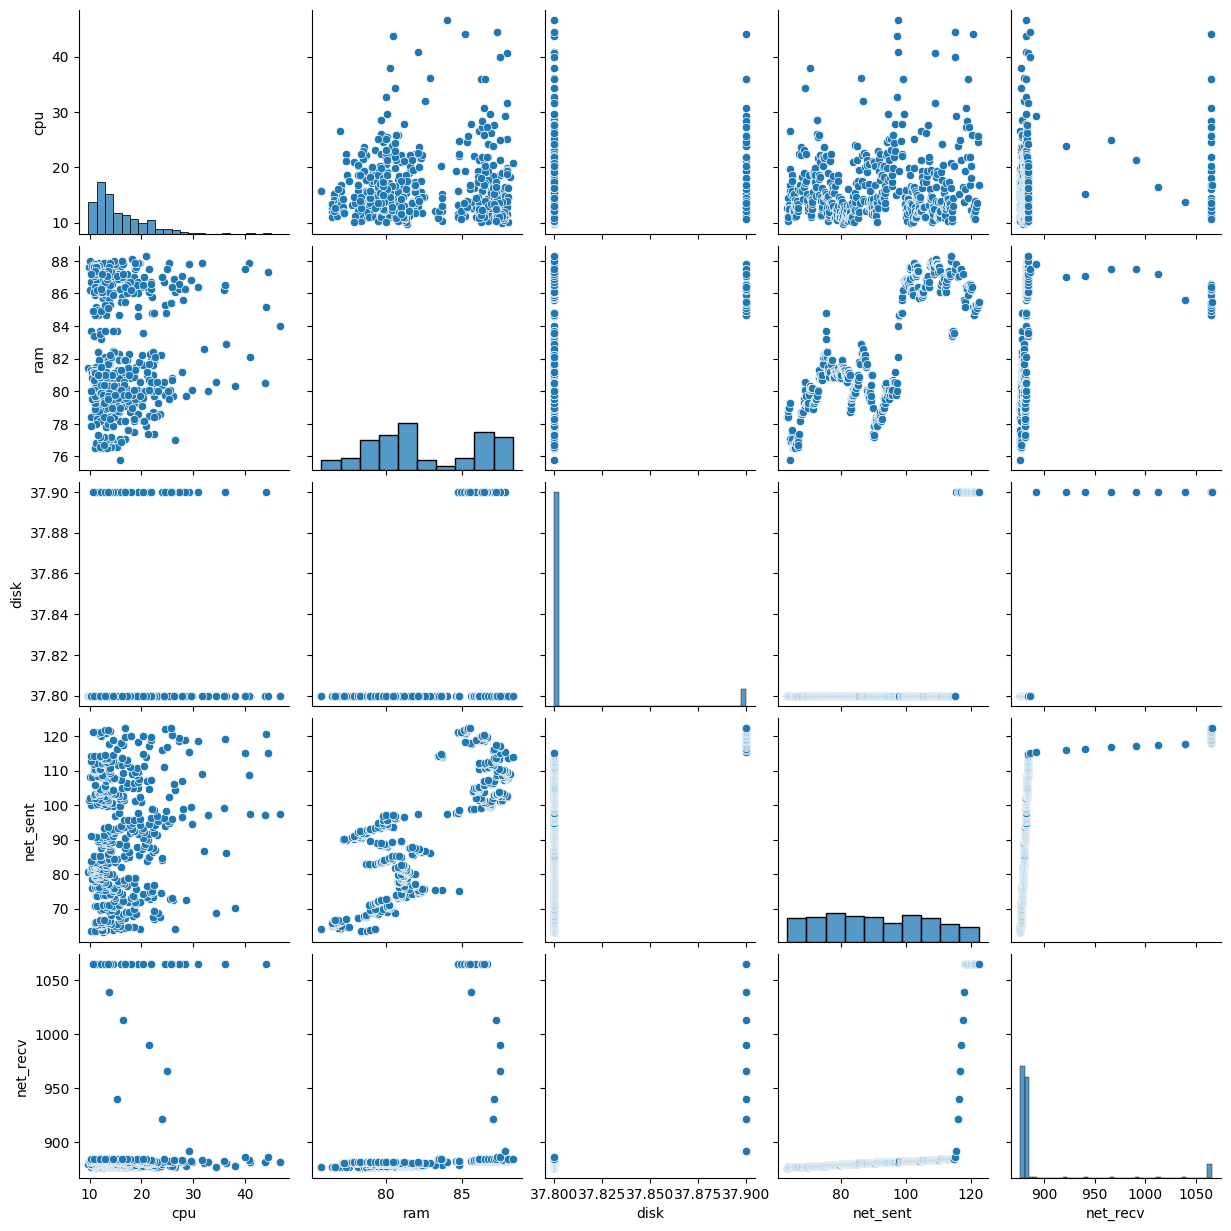

In [5]:
# Pairplot
sns.pairplot(df, vars=["cpu","ram","disk","net_sent","net_recv"])
plt.savefig("pairplot.png")
plt.show()

## TRAINING the models 

In [7]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, HDBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import joblib
import numpy as np

In [8]:
df

timestamp   cpu   ram  disk    net_sent     net_recv  notepad_running
0    07:33:28  12.6  78.4  37.8   63.401973   876.555230                0
1    07:33:33  11.2  78.4  37.8   63.478015   876.567491                0
2    07:33:38  10.3  78.4  37.8   63.563416   876.589496                0
3    07:33:43  11.1  78.8  37.8   63.639262   876.600947                0
4    07:33:48  14.5  79.0  37.8   63.729137   876.615638                0
..        ...   ...   ...   ...         ...          ...              ...
495  08:15:07  12.9  85.3  37.9  121.773097  1065.243807                0
496  08:15:12  13.5  85.1  37.9  121.880112  1065.282935                0
497  08:15:17  24.6  85.3  37.9  122.108528  1065.325688                0
498  08:15:22  25.6  85.4  37.9  122.290592  1065.394284                0
499  08:15:27  16.9  85.5  37.9  122.423190  1065.445098                0

[500 rows x 7 columns]

In [9]:
# X = df[["cpu", "ram", "disk", "net_sent", "net_recv"]]
X = df[["cpu", "ram", "net_sent", "net_recv"]]

X.head(5)

cpu   ram   net_sent    net_recv
0  12.6  78.4  63.401973  876.555230
1  11.2  78.4  63.478015  876.567491
2  10.3  78.4  63.563416  876.589496
3  11.1  78.8  63.639262  876.600947
4  14.5  79.0  63.729137  876.615638

In [10]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled[:10]

array([[-0.61035974, -1.16529147, -1.67186172, -0.36059522],
       [-0.84707746, -1.16529147, -1.66724287, -0.36031904],
       [-0.99925314, -1.16529147, -1.66205558, -0.35982335],
       [-0.86398587, -1.05081714, -1.65744861, -0.35956539],
       [-0.28909997, -0.99357997, -1.65198953, -0.35923448],
       [-0.50890929, -0.99357997, -1.64583185, -0.35873605],
       [-0.61035974, -0.99357997, -1.64090032, -0.35849388],
       [-0.64417656, -0.99357997, -1.63624335, -0.35831766],
       [ 0.59013728, -0.90772422, -1.62993217, -0.35810728],
       [-0.06929066, -1.90937464, -1.62470179, -0.3578679 ]])

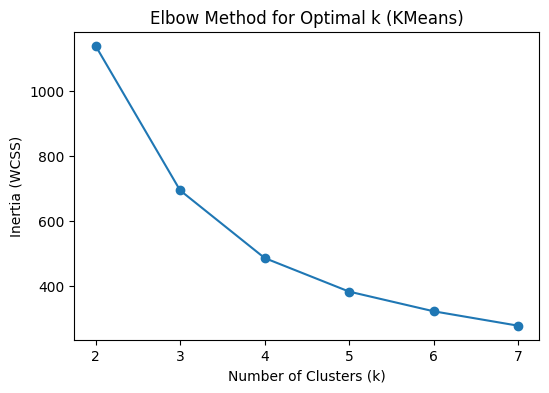

In [11]:
inertias = []
K_range = range(2, 8)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, inertias, marker="o")
plt.title("Elbow Method for Optimal k (KMeans)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.show()

In [13]:
optimal_k = 2 # You can pick based on the elbow curve. we chose 2 because we want only 2 categories

# -------------------------------
# Try Multiple Models
# -------------------------------
models = {
    "KMeans": KMeans(n_clusters=optimal_k, random_state=42, n_init=10),
    "Agglomerative": AgglomerativeClustering(n_clusters=optimal_k),
    "DBSCAN_1.5_5": DBSCAN(eps=1.5, min_samples=5),
    "HDBSCAN": HDBSCAN(min_cluster_size = 20)
}


In [14]:
def train_models(X, models: dict) -> tuple:
    """Train the given model in dictionary 'models' on  data 'X' "
    Return best model and result list of dictionary with name, trained model, labels, silhouette_score, davies_bouldin_score"""

    results = []

    for name, model in models.items():
        labels = model.fit_predict(X_scaled)

        if len(set(labels)) > 1:
            sil = silhouette_score(X_scaled, labels)
            db = davies_bouldin_score(X_scaled, labels)
        else:
            sil, db = -1, 999  # Poor scores if only 1 cluster

        results.append(
            {"model": name, "object": model, "labels": labels, "silhouette": sil, "davies_bouldin": db}
        )
    
    best_model = sorted(results, key=lambda x: (-x["silhouette"], x["davies_bouldin"]))[0]
    for r in results:
        print(f"{r['model']}: clusters={len(set(r['labels']))}, silhouette={r['silhouette']:.5f}, db={r['davies_bouldin']:.5f}")
        
    return (best_model, results)

In [15]:
best_model, results = train_models(X, models)
print(f"\n✅ Best Model Selected: {best_model['model']}")

KMeans: clusters=2, silhouette=0.49568, db=0.97388
Agglomerative: clusters=2, silhouette=0.48897, db=1.00553
DBSCAN_1.5_5: clusters=2, silhouette=0.58925, db=0.58870
HDBSCAN: clusters=4, silhouette=0.52448, db=0.99533

✅ Best Model Selected: DBSCAN_1.5_5


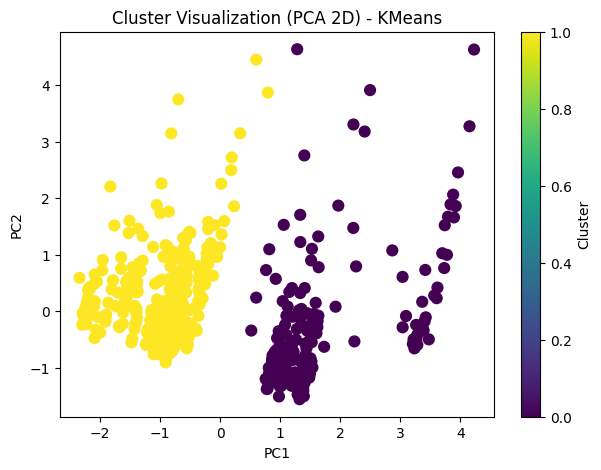

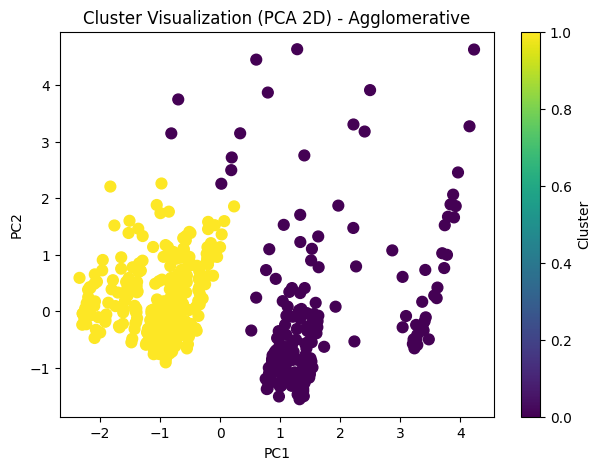

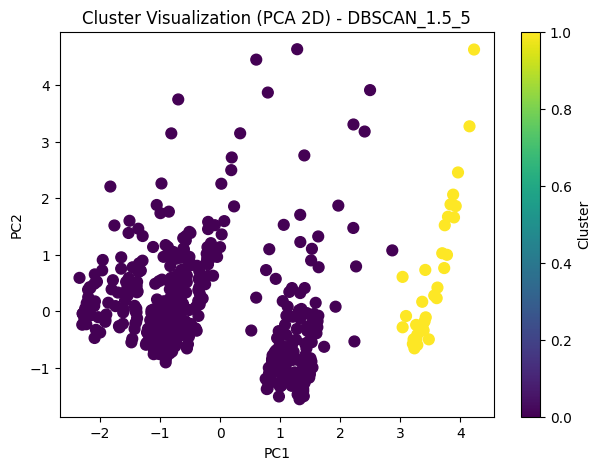

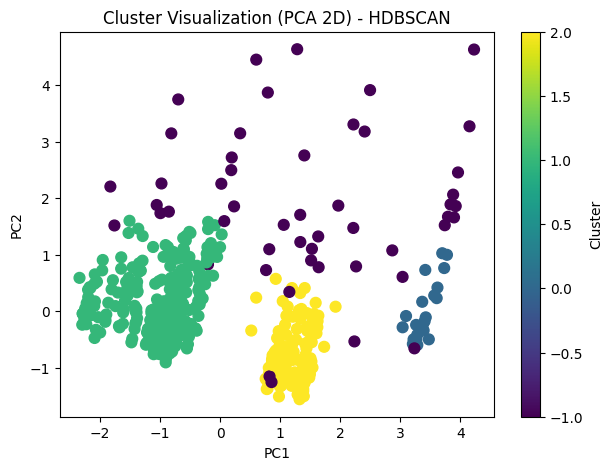

In [16]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_pca = pd.DataFrame(X_pca, columns=["PC1", "PC2"])

def visualize_clusters(results):
    global X_pca, df_pca

    for model in results:
        df_pca["cluster"] = model["labels"]
        plt.figure(figsize=(7, 5))
        plt.scatter(df_pca["PC1"], df_pca["PC2"], c=df_pca["cluster"], cmap="viridis", s=60)
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.title(f"Cluster Visualization (PCA 2D) - {model['model']}")
        plt.colorbar(label="Cluster")
        plt.show()

visualize_clusters(results)

In [17]:
# Parameter grid for DBSCAN
eps_values = np.arange(0.5, 2.5, 0.1)
# print(eps_values)
min_samples_values = range(3, 6)

best_score = -1
best_params = None

for min_samples in min_samples_values:
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        # Ignore cases where all points are noise or only one cluster
        if len(set(labels)) > 1 and len(set(labels)) < len(X_scaled):
            #this maximize silhouette and minimize the DB score
            score = silhouette_score(X_scaled, labels) - davies_bouldin_score(X_scaled, labels)    
            print(f"score = {score:<5.4f} when eps = {eps:<5.4f} min_samples = {min_samples:<5.4f}")
            if score > best_score:
                best_score = score
                best_params = {"eps": round(eps, 4), "min_samples": min_samples}

print(f"Best DBSCAN params: {best_params}, combined score: {best_score:.3f}")

score = -0.6210 when eps = 0.5000 min_samples = 3.0000
score = -0.4577 when eps = 0.6000 min_samples = 3.0000
score = -0.3992 when eps = 0.7000 min_samples = 3.0000
score = -0.5448 when eps = 0.8000 min_samples = 3.0000
score = -0.4874 when eps = 0.9000 min_samples = 3.0000
score = -0.5554 when eps = 1.0000 min_samples = 3.0000
score = -0.9736 when eps = 1.1000 min_samples = 3.0000
score = -0.6956 when eps = 1.2000 min_samples = 3.0000
score = 0.3392 when eps = 1.3000 min_samples = 3.0000
score = 0.3392 when eps = 1.4000 min_samples = 3.0000
score = -0.9210 when eps = 0.5000 min_samples = 4.0000
score = -0.4462 when eps = 0.6000 min_samples = 4.0000
score = -0.3800 when eps = 0.7000 min_samples = 4.0000
score = -0.3472 when eps = 0.8000 min_samples = 4.0000
score = -0.2333 when eps = 0.9000 min_samples = 4.0000
score = -0.3432 when eps = 1.0000 min_samples = 4.0000
score = -0.2988 when eps = 1.1000 min_samples = 4.0000
score = -0.7271 when eps = 1.2000 min_samples = 4.0000
score = 0.11

In [18]:
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [19]:
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)
df_pca_3d = pd.DataFrame(X_pca_3d, columns=["PC1", "PC2", "PC3"])
df_pca_3d

PC1       PC2       PC3
0   -2.027975 -0.106512  0.599540
1   -2.065306 -0.330018  0.667589
2   -2.087730 -0.473949  0.711330
3   -1.994660 -0.376710  0.620773
4   -1.859365  0.149208  0.428741
..        ...       ...       ...
495  3.389055 -0.341086  2.829689
496  3.377531 -0.231504  2.825889
497  3.740899  1.519453  2.257247
498  3.794330  1.670046  2.195558
499  3.565518  0.276440  2.607702

[500 rows x 3 columns]

In [20]:
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)
df_pca_3d = pd.DataFrame(X_pca_3d, columns=["PC1", "PC2", "PC3"])

def visualize_clusters_3d(results):
    global X_pca_3d, df_pca_3d

    for model in results:
        # df_pca_3d["cluster"] = 
        trace = go.Scatter3d(x=df_pca_3d["PC1"], y=df_pca_3d["PC2"], z=df_pca_3d["PC3"],
                             mode='markers',
                             marker=dict(
                                 size=8,
                                 color=model["labels"],  # Array for coloring
                                 colorscale='Viridis', # Example colorscale
                                 opacity=0.7,
                                 colorbar=dict(title='Color Scale') # Optional: add a color bar)
                             )
        )
        data = [trace]
        layout = go.Layout(scene=dict(xaxis_title='PC1', yaxis_title='PC2', zaxis_title='PC3'), title=dict(text = model["model"]))
        fig = go.Figure(data=data, layout=layout)
        iplot(fig)



In [19]:
# visualize_clusters_3d(search_DBSCAN_results)
visualize_clusters_3d(results)

In [21]:
def model_evaluation_on_data(model, cat_1="cat_1", cat_2="cat_2"):
    global X
    labels_final = model["labels"]
    name_categories = lambda label: {0: cat_1, 1: cat_2}.get(label, 0)
    result_data = pd.concat([X, pd.Series(labels_final, name="category")], axis=1)
    result_data["category"] = result_data["category"].apply(name_categories)
    print(f"{'-'*15}{cat_1:-^15}{'-'*15}")
    print(result_data.loc[result_data["category"] == cat_1].describe())
    print(f"{'-'*15}{cat_2:-^15}{'-'*15}")
    print(result_data.loc[result_data["category"] == cat_2].describe())
    return result_data

In [22]:
print(f"{'='*15}{'X':=^15}{'='*15}", X.describe(), sep='\n')

result_data_all = []
for model in results:
    print(f"{'='*15}{model["model"]:=^15}{'='*15}")
    model_name = model["model"]
    cat_1 = "low" if model_name.startswith("DBSCAN") else "high" 
    cat_2 = "low" if cat_1 == "high" else "high"
    result_data_all.append({"model_name": model_name, "evaluation_data": model_evaluation_on_data(model, cat_1, cat_2)})

======================X======================
             cpu         ram    net_sent     net_recv
count  500.00000  500.000000  500.000000   500.000000
mean    16.20980   82.471800   90.926576   892.563261
std      5.92014    3.497733   16.479933    44.437813
min      9.80000   75.800000   63.401973   876.555230
25%     12.20000   79.800000   77.077511   878.897276
50%     14.20000   81.200000   89.987561   881.003050
75%     18.60000   86.300000  104.544653   883.146357
max     46.60000   88.300000  122.423190  1065.445098
===================KMeans====================
--------------------high---------------------
              cpu         ram    net_sent     net_recv
count  189.000000  189.000000  189.000000   189.000000
mean    16.605291   86.579365  108.972955   914.352044
std      6.857460    1.055153    6.796361    66.855790
min      9.900000   83.400000   97.591340   882.132597
25%     12.200000   86.100000  103.229532   882.894254
50%     14.200000   86.700000  108.489504   88

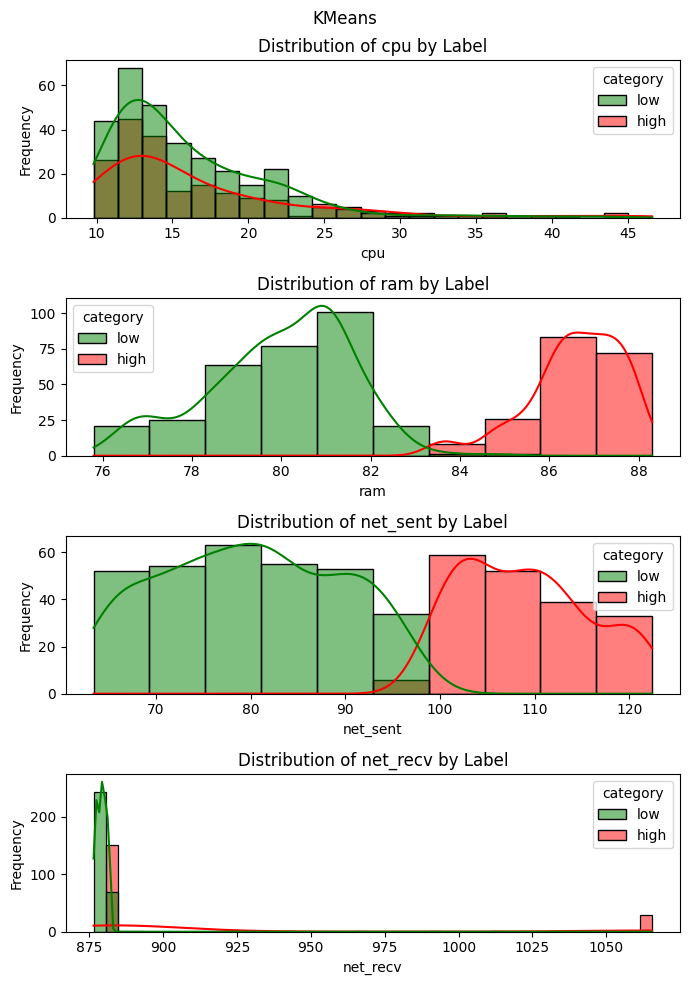

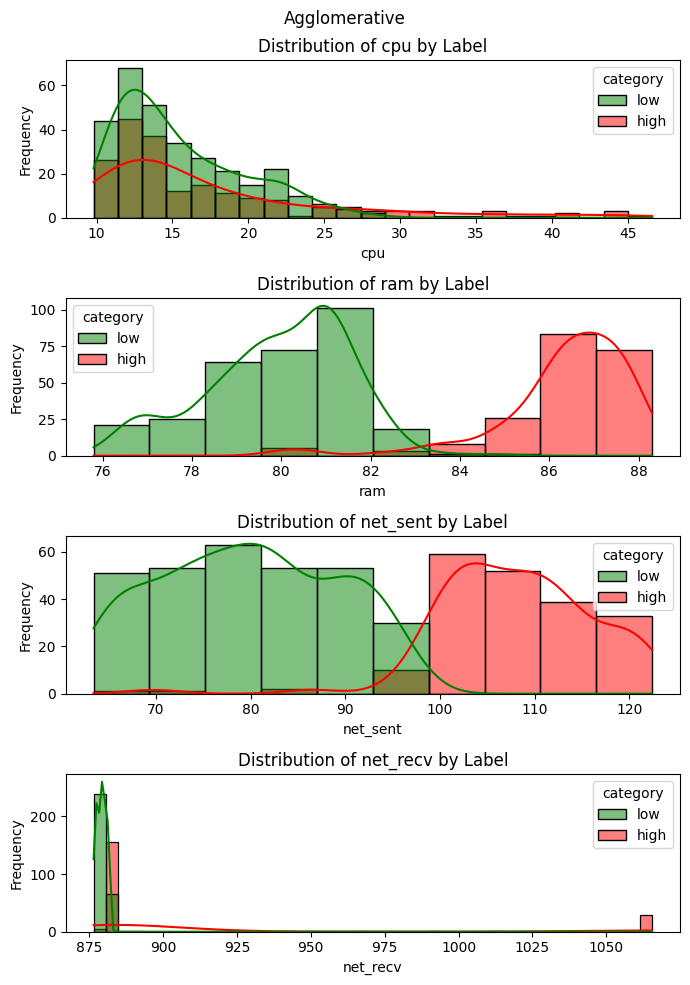

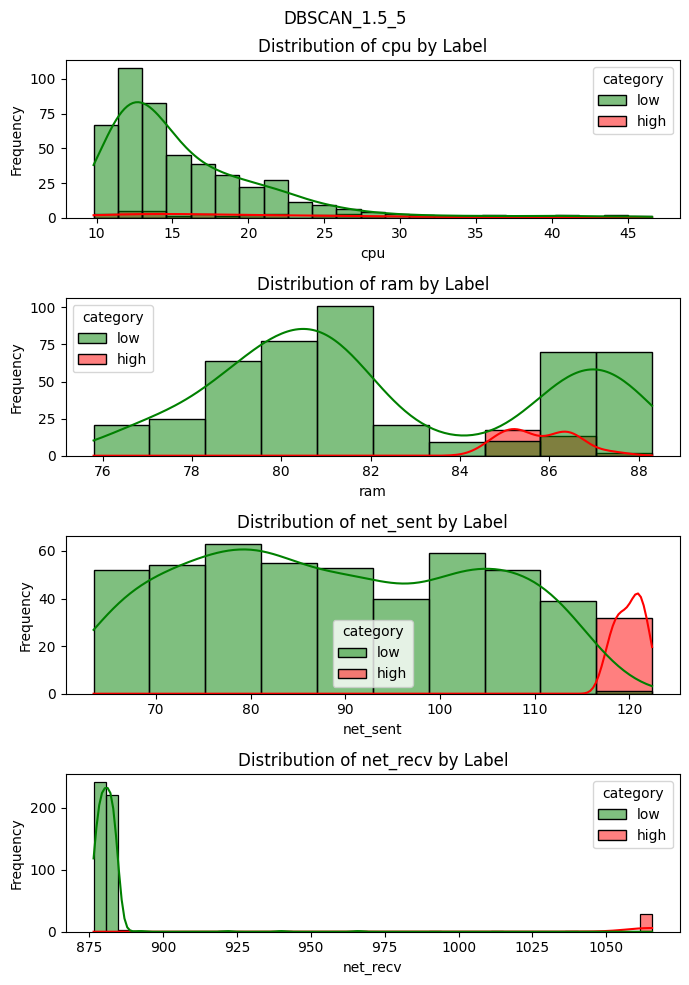

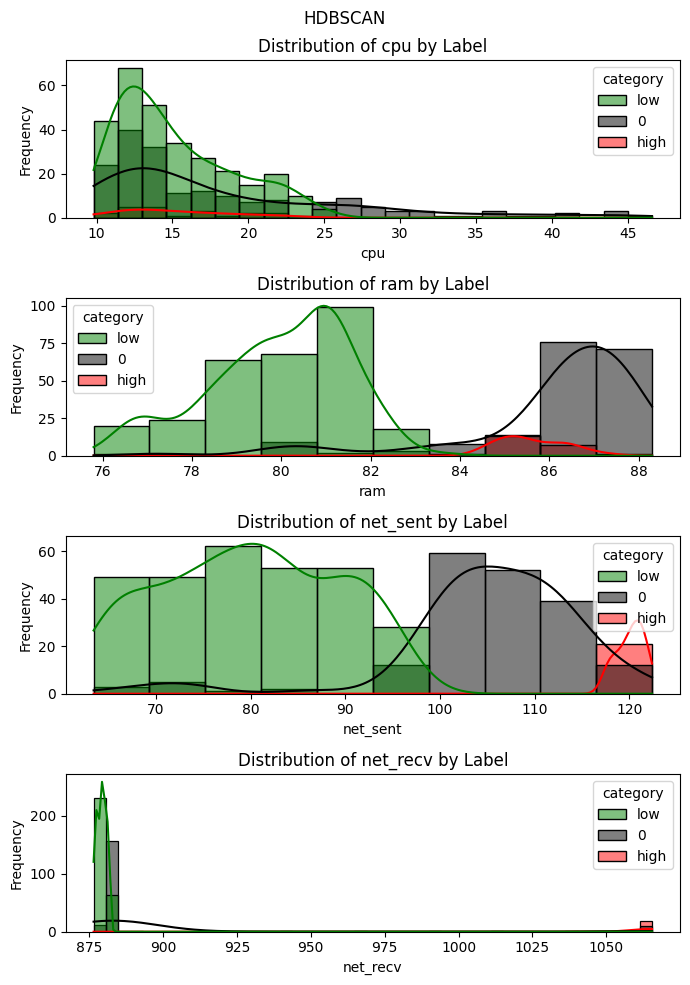

In [23]:
for model_result in result_data_all:
    numerical_cols = model_result["evaluation_data"].select_dtypes(include=np.number).columns

    plt.figure(figsize=(7, 10))
    for i, col in enumerate(numerical_cols):
        plt.subplot(len(numerical_cols), 1, i + 1)
        sns.histplot(data=model_result["evaluation_data"], x=col, hue='category', palette={'high': 'red', 'low': 'green'}, kde=True) # Use hue for coloring by label and palette to set specific colors
        plt.title(f'Distribution of {col} by Label')
        plt.tight_layout()
        plt.xlabel(col)
        plt.suptitle(f"{model_result["model_name"]}")
        plt.ylabel('Frequency' if df[col].dtype != 'object' else 'Count')

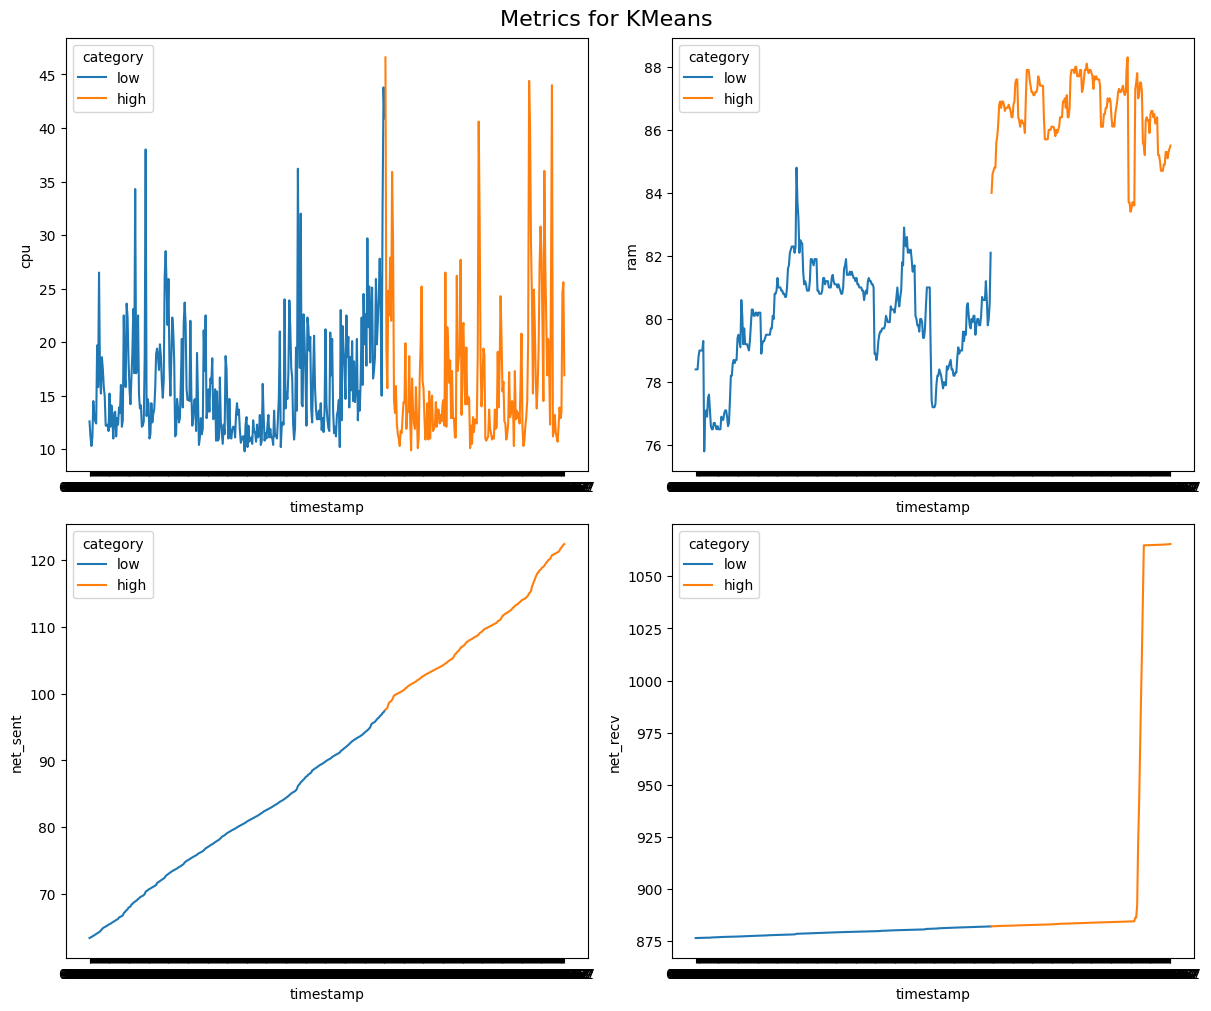

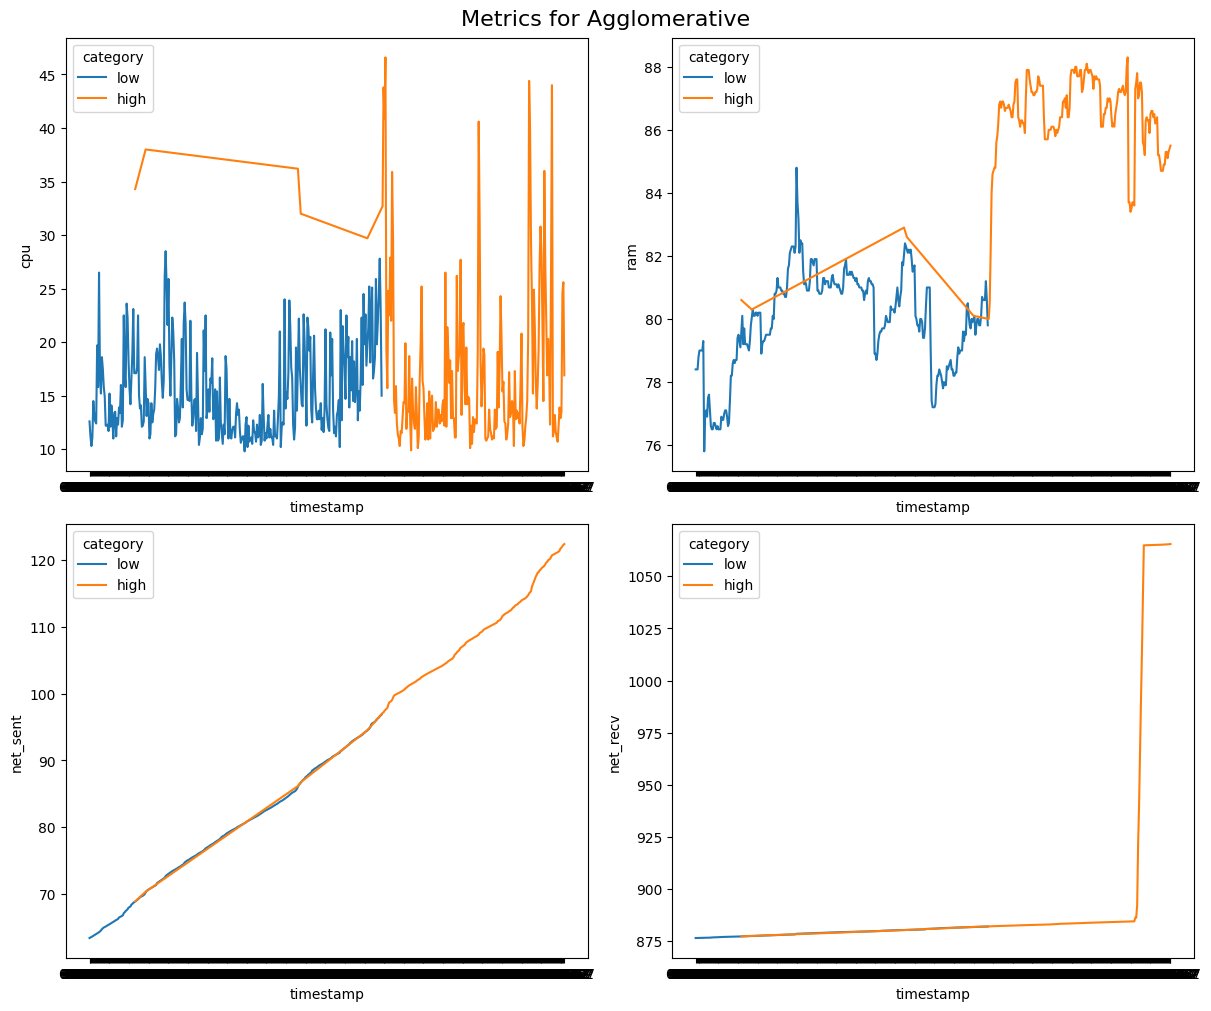

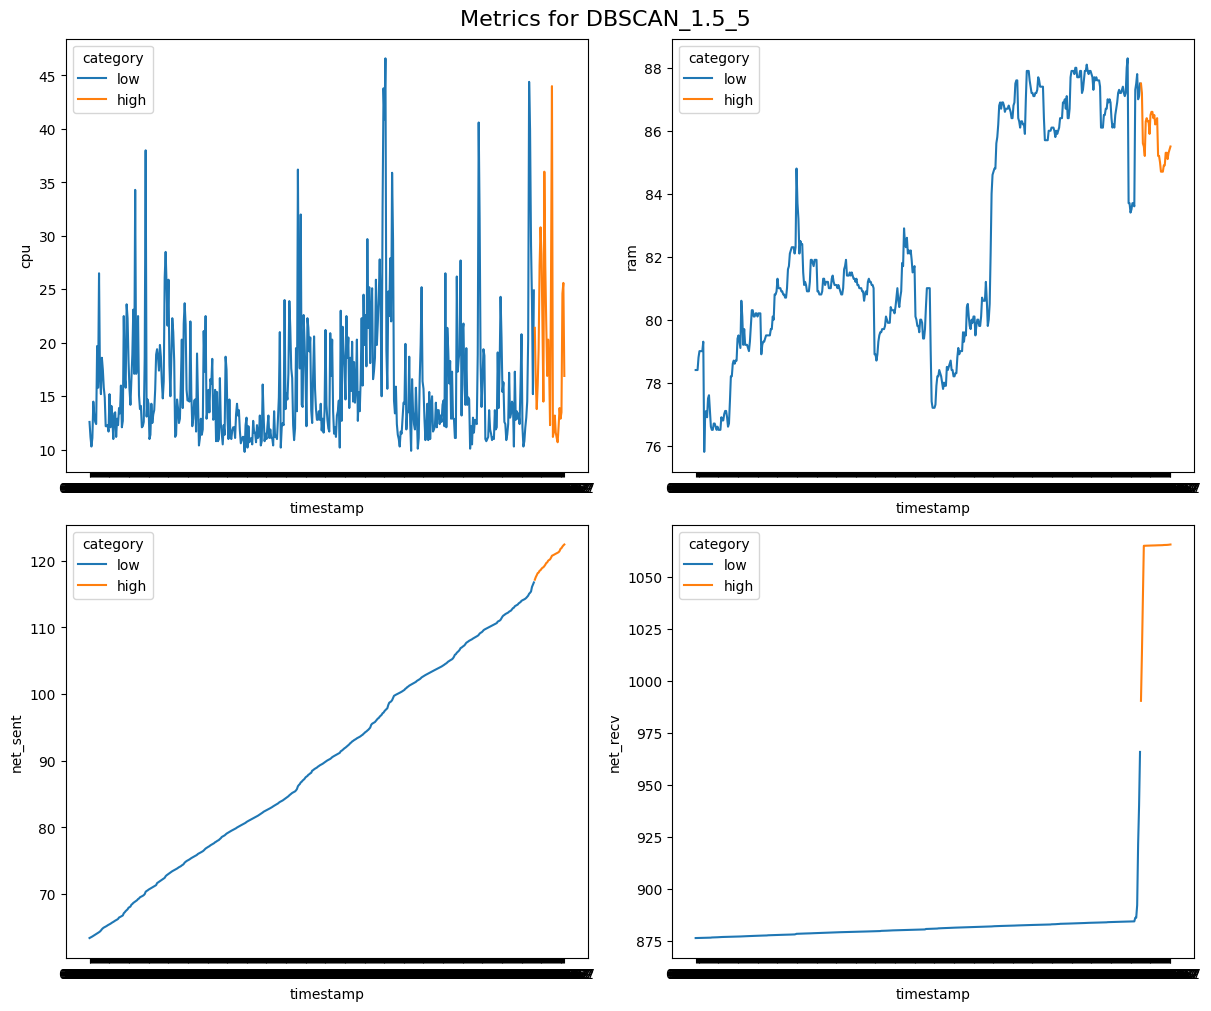

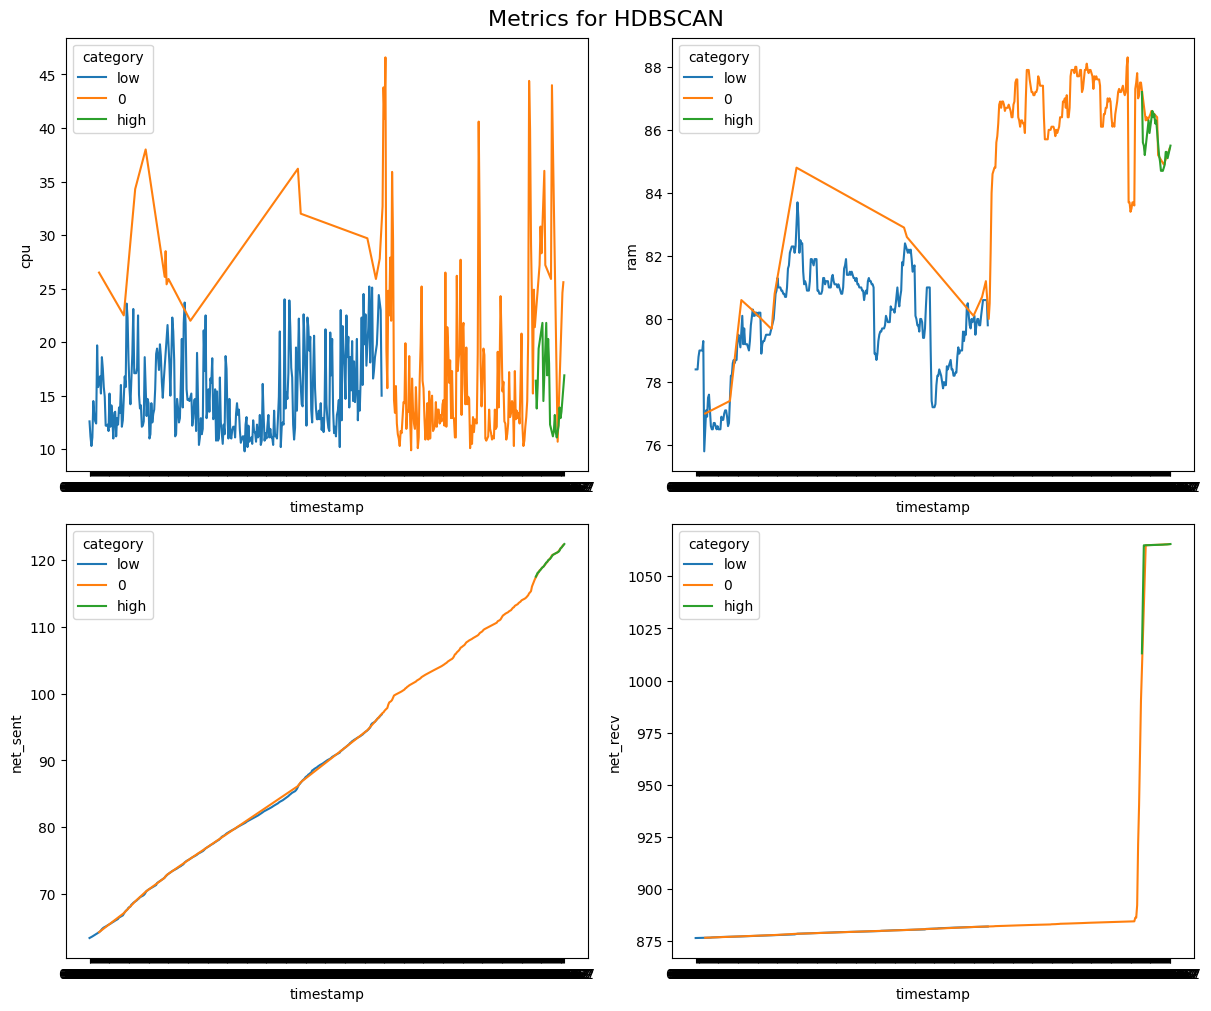

In [ ]:
from matplotlib import gridspec
for model_result in result_data_all:
    fig = plt.figure(figsize=(12, 10), constrained_layout=True)
    gs = gridspec.GridSpec(2, 2, figure=fig) # Define a 2x2 grid for the current figure
    fig.suptitle(f'Metrics for {model_result["model_name"]}', fontsize=16)
    ax_list = [fig.add_subplot(gs[i, j]) for i in range (2) for j in range (2)]
    for ax, metric in zip(ax_list, X.columns):
        sns.scatterplot(x=df["timestamp"], y=df[metric], hue=model_result["evaluation_data"]["category"], data=df, ax=ax)
    plt.show()

### HYPERPARAMETER Tuning

DBSCAN_1.20_3: clusters=2, silhouette=0.47386, db=1.16945
DBSCAN_1.30_3: clusters=2, silhouette=0.61168, db=0.27246
DBSCAN_1.40_3: clusters=2, silhouette=0.61168, db=0.27246
DBSCAN_1.50_3: clusters=1, silhouette=-1.00000, db=999.00000
DBSCAN_1.60_3: clusters=1, silhouette=-1.00000, db=999.00000
DBSCAN_1.20_4: clusters=4, silhouette=0.51751, db=1.24462
DBSCAN_1.30_4: clusters=3, silhouette=0.57408, db=0.45953
DBSCAN_1.40_4: clusters=3, silhouette=0.57408, db=0.45953
DBSCAN_1.50_4: clusters=2, silhouette=0.58925, db=0.58870
DBSCAN_1.60_4: clusters=1, silhouette=-1.00000, db=999.00000
DBSCAN_1.20_5: clusters=3, silhouette=0.56168, db=0.86053
DBSCAN_1.30_5: clusters=3, silhouette=0.57244, db=0.62013
DBSCAN_1.40_5: clusters=3, silhouette=0.57244, db=0.62013
DBSCAN_1.50_5: clusters=2, silhouette=0.58925, db=0.58870
DBSCAN_1.60_5: clusters=2, silhouette=0.59051, db=0.58086


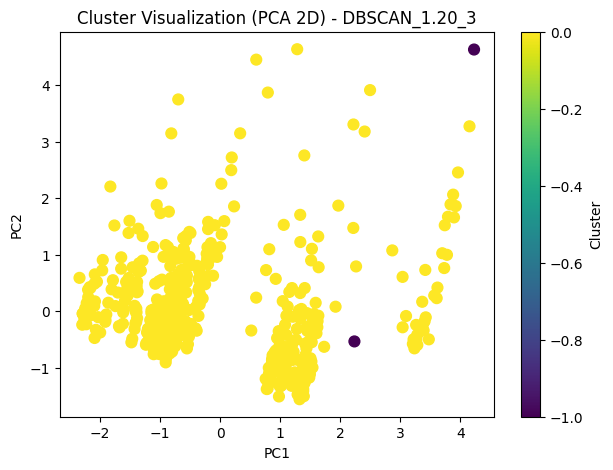

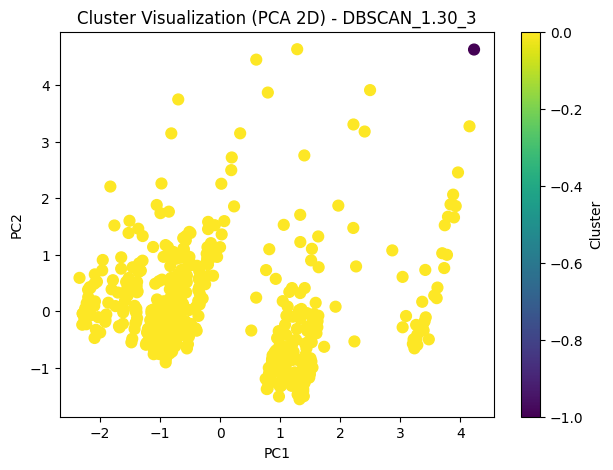

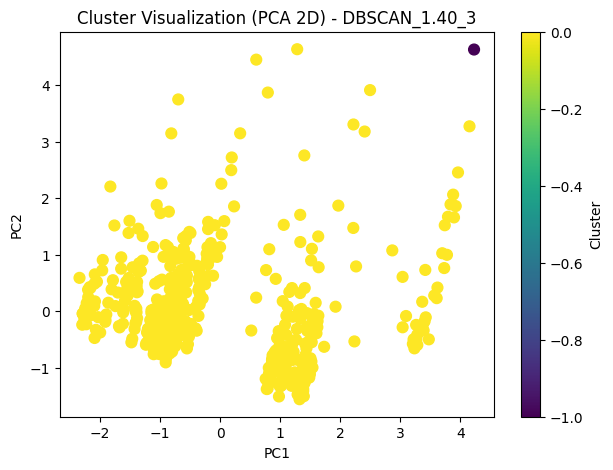

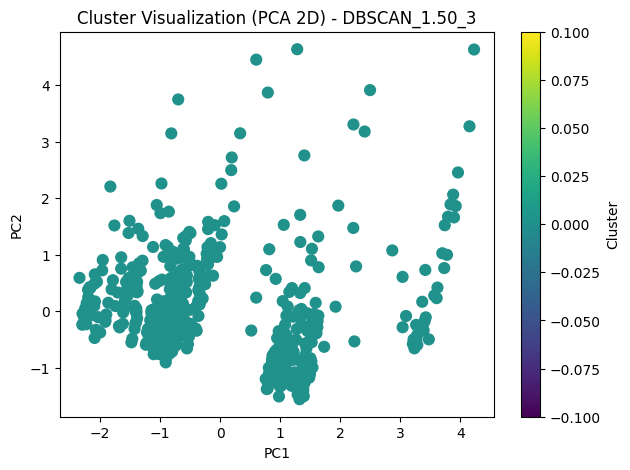

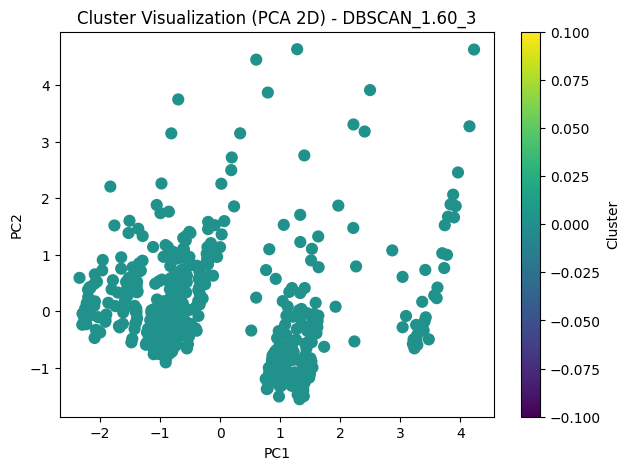

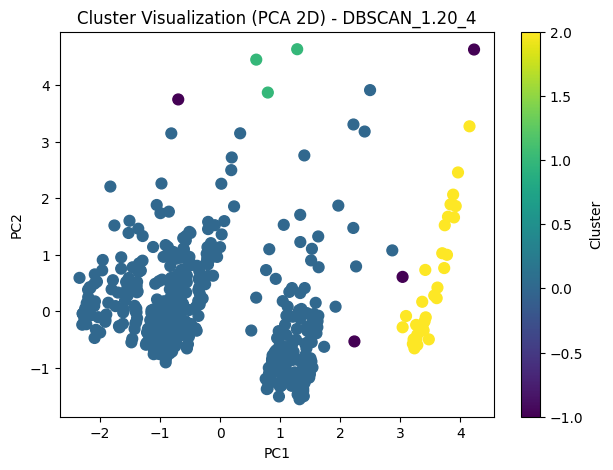

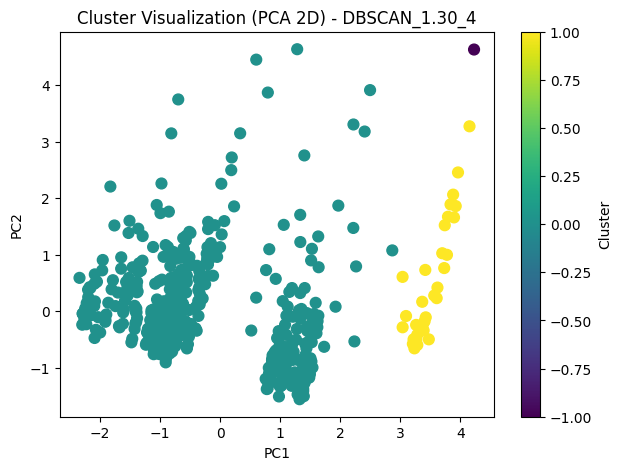

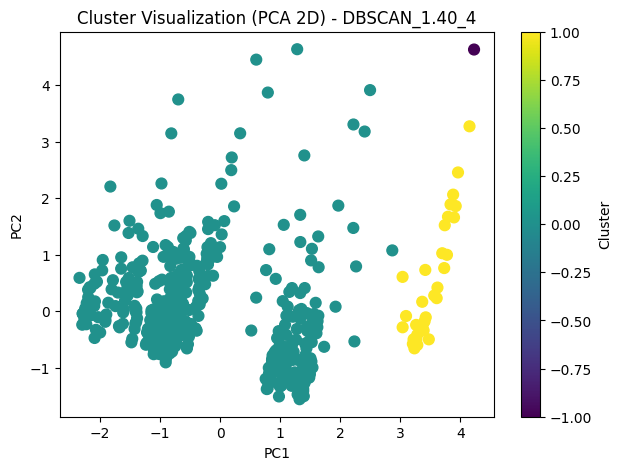

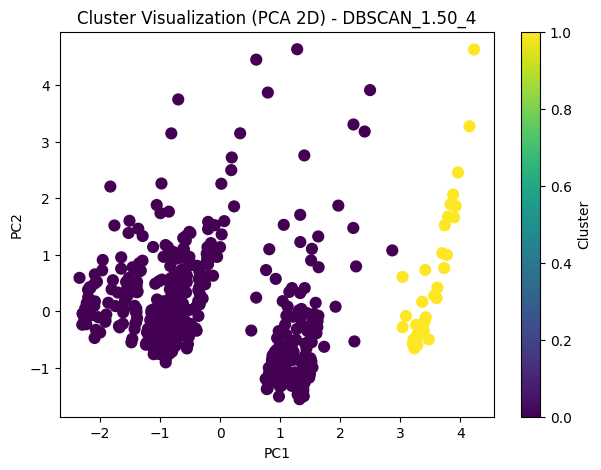

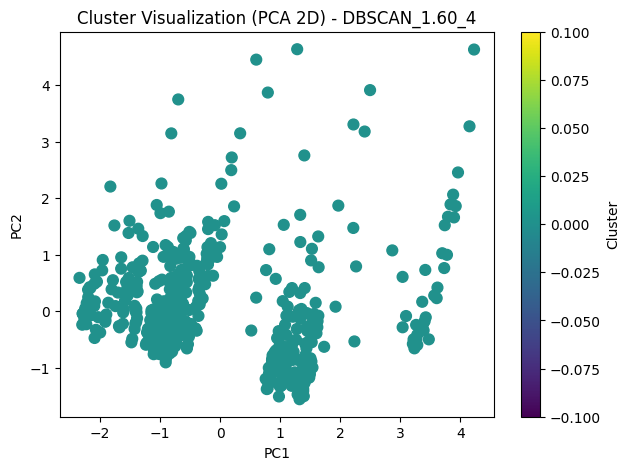

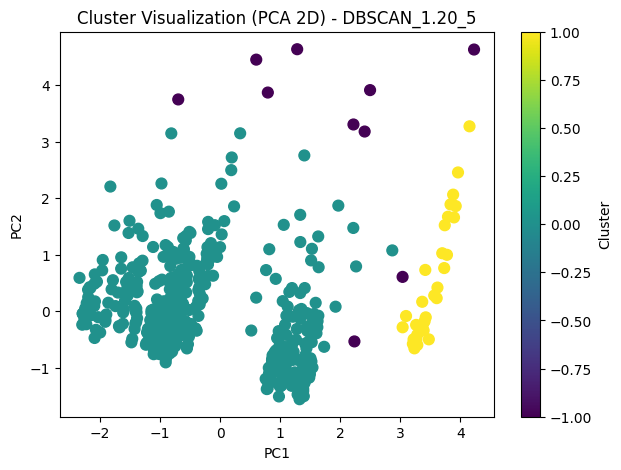

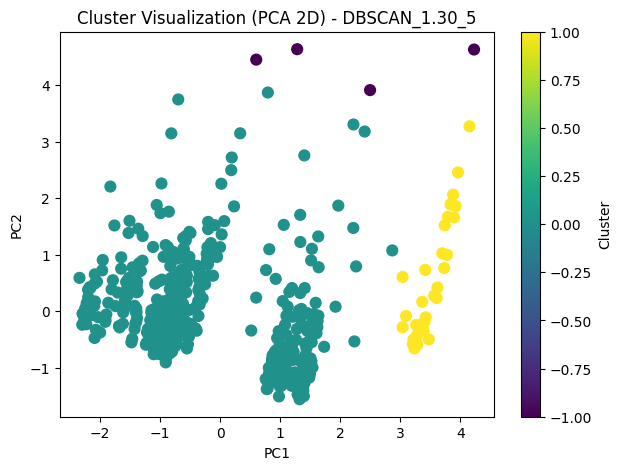

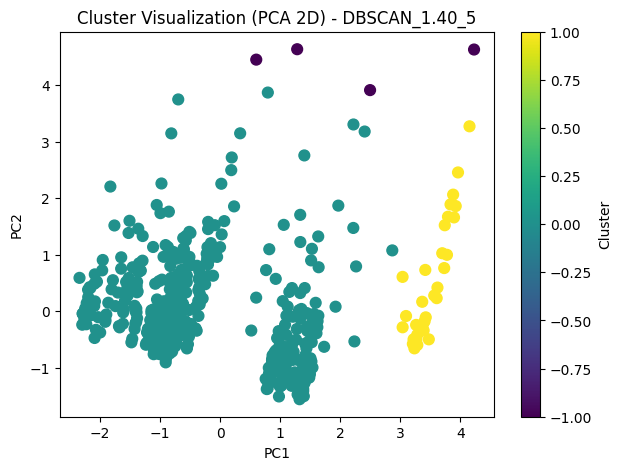

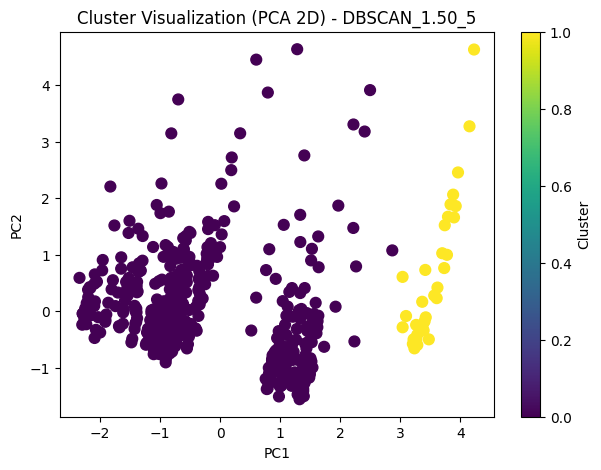

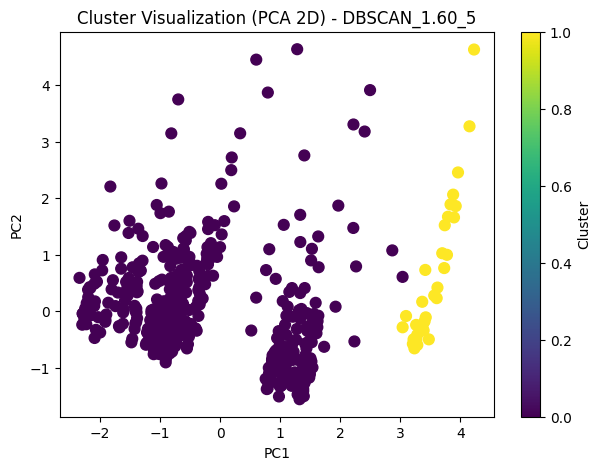

In [25]:
eps_values = np.arange(1.2, 1.6, 0.1)
# print(eps_values)
min_samples_values = range(3, 6)

search_DBSCAN_models = {}

for min_samples in min_samples_values:
    for eps in eps_values:
        search_DBSCAN_models[f"DBSCAN_{eps:.2f}_{min_samples}"] = DBSCAN(eps=eps, min_samples=min_samples)

best_DBSCAN_model, search_DBSCAN_results = train_models(X, search_DBSCAN_models)
# print(best_DBSCAN_model)
visualize_clusters(search_DBSCAN_results)

In [26]:
min_cluster_sizes = range(2, 101, 1)
# print(eps_values)
min_samples_values = range(1, 101, 1)

search_HDBSCAN_models = {}

for min_cluster_size in min_cluster_sizes:
    for min_samples_value in min_samples_values:
        search_HDBSCAN_models[f"HDBSCAN_{min_cluster_size}_{min_samples_value}"] = HDBSCAN(min_cluster_size = min_cluster_size, min_samples = min_samples_value)

print(search_HDBSCAN_models)

best_HDBSCAN_model, search_HDBSCAN_results = train_models(X, search_HDBSCAN_models)
# print(best_HDBSCAN_model)
# visualize_clusters(search_HDBSCAN_results)

{'HDBSCAN_2_1': HDBSCAN(min_cluster_size=2, min_samples=1), 'HDBSCAN_2_2': HDBSCAN(min_cluster_size=2, min_samples=2), 'HDBSCAN_2_3': HDBSCAN(min_cluster_size=2, min_samples=3), 'HDBSCAN_2_4': HDBSCAN(min_cluster_size=2, min_samples=4), 'HDBSCAN_2_5': HDBSCAN(min_cluster_size=2, min_samples=5), 'HDBSCAN_2_6': HDBSCAN(min_cluster_size=2, min_samples=6), 'HDBSCAN_2_7': HDBSCAN(min_cluster_size=2, min_samples=7), 'HDBSCAN_2_8': HDBSCAN(min_cluster_size=2, min_samples=8), 'HDBSCAN_2_9': HDBSCAN(min_cluster_size=2, min_samples=9), 'HDBSCAN_2_10': HDBSCAN(min_cluster_size=2, min_samples=10), 'HDBSCAN_2_11': HDBSCAN(min_cluster_size=2, min_samples=11), 'HDBSCAN_2_12': HDBSCAN(min_cluster_size=2, min_samples=12), 'HDBSCAN_2_13': HDBSCAN(min_cluster_size=2, min_samples=13), 'HDBSCAN_2_14': HDBSCAN(min_cluster_size=2, min_samples=14), 'HDBSCAN_2_15': HDBSCAN(min_cluster_size=2, min_samples=15), 'HDBSCAN_2_16': HDBSCAN(min_cluster_size=2, min_samples=16), 'HDBSCAN_2_17': HDBSCAN(min_cluster_size=

In [23]:
SHDBR = pd.DataFrame(search_HDBSCAN_results)
SHDBR = SHDBR[["model", "silhouette", "davies_bouldin"]]
SHDBR.head()

NameError: name 'search_HDBSCAN_results' is not defined

In [55]:
SHDBR_sorted = SHDBR.sort_values(by=["silhouette", "davies_bouldin"], ascending=False)
# SHDBR.sort_values(by=["silhouette", "davies_bouldin"], key=lambda x: (-x["silhouette"], x["davies_bouldin"]), ascending=False)
SHDBR_sorted.head(50)

model  silhouette  davies_bouldin
503    HDBSCAN_7_4    0.553169        0.725318
603    HDBSCAN_8_4    0.553169        0.725318
703    HDBSCAN_9_4    0.553169        0.725318
803   HDBSCAN_10_4    0.553169        0.725318
903   HDBSCAN_11_4    0.553169        0.725318
1003  HDBSCAN_12_4    0.553169        0.725318
1103  HDBSCAN_13_4    0.553169        0.725318
1203  HDBSCAN_14_4    0.553169        0.725318
1303  HDBSCAN_15_4    0.553169        0.725318
1403  HDBSCAN_16_4    0.553169        0.725318
1503  HDBSCAN_17_4    0.553169        0.725318
1603  HDBSCAN_18_4    0.553169        0.725318
1703  HDBSCAN_19_4    0.553169        0.725318
1803  HDBSCAN_20_4    0.553169        0.725318
1903  HDBSCAN_21_4    0.553169        0.725318
2003  HDBSCAN_22_4    0.553169        0.725318
2103  HDBSCAN_23_4    0.553169        0.725318
2203  HDBSCAN_24_4    0.553169        0.725318
2303  HDBSCAN_25_4    0.553169        0.725318
2403  HDBSCAN_26_4    0.553169        0.725318
2503  HDBSCAN_27_4    0.553169        0.725318
2603  HDBSCAN_28_4    0.553169        0.725318
2703  HDBSCAN_29_4    0.553169        0.725318
2803  HDBSCAN_30_4    0.553169        0.725318
2903  HDBSCAN_31_4    0.553169        0.725318
504    HDBSCAN_7_5    0.551934        0.754210
604    HDBSCAN_8_5    0.551934        0.754210
704    HDBSCAN_9_5    0.551934        0.754210
804   HDBSCAN_10_5    0.551934        0.754210
904   HDBSCAN_11_5    0.551934        0.754210
1004  HDBSCAN_12_5    0.551934        0.754210
1104  HDBSCAN_13_5    0.551934        0.754210
1204  HDBSCAN_14_5    0.551934        0.754210
1304  HDBSCAN_15_5    0.551934        0.754210
1404  HDBSCAN_16_5    0.551934        0.754210
1504  HDBSCAN_17_5    0.551934        0.754210
1604  HDBSCAN_18_5    0.551934        0.754210
1704  HDBSCAN_19_5    0.551934        0.754210
1804  HDBSCAN_20_5    0.551934        0.754210
1904  HDBSCAN_21_5    0.551934        0.754210
2004  HDBSCAN_22_5    0.551934        0.754210
2104  HDBSCAN_23_5    0.551934        0.754210
2204  HDBSCAN_24_5    0.551934        0.754210
2304  HDBSCAN_25_5    0.551934        0.754210
2404  HDBSCAN_26_5    0.551934        0.754210
2504  HDBSCAN_27_5    0.551934        0.754210
2604  HDBSCAN_28_5    0.551934        0.754210
2704  HDBSCAN_29_5    0.551934        0.754210
2804  HDBSCAN_30_5    0.551934        0.754210
2904  HDBSCAN_31_5    0.551934        0.754210